# COVID Testing and Health Equity 


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
pd.options.display.float_format = "{:,.0f}".format


## 1. Import and clean MTA turnstile data
Source: http://web.mta.info/developers/turnstile.html

In [2]:
# Load data from April, May, and June 2019, data is loaded on Saturdays.

def get_data_parse_dt(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], usecols = [0,1,2,3,4,6,7,8,9], keep_date_col=True))
    return pd.concat(dfs)

# Create a datetime column using data from columns DATE and TIME during import
week_nums = [190406, 190413, 190420, 190427, 190504, 190511, 190518, 190525, 190601, 190608, 190615, 190622, 190629]
df = get_data_parse_dt(week_nums)


In [3]:
# How many unique values in each column
df.nunique()
# There are 378 stations

DATE_TIME     172268
C/A              747
UNIT             469
SCP              223
STATION          378
LINENAME         114
DATE              91
TIME           64013
DESC               2
ENTRIES      1909914
dtype: int64

In [4]:
df.columns

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DATE',
       'TIME', 'DESC', 'ENTRIES'],
      dtype='object')

In [5]:
# Strip whitespace from column names
df.columns = [column.strip() for column in df.columns]
df.columns

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DATE',
       'TIME', 'DESC', 'ENTRIES'],
      dtype='object')

## 2. Select late night entry data

In [6]:
late_night_mask = df.copy()

In [7]:
# Mask selects the interval between 12:00 AM and 4:00 AM 
late_night_mask = (df['TIME'] == '04:00:00')
late_night_df = df[late_night_mask]
late_night_df.head(2)

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/30/2019,04:00:00,REGULAR,6999084
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/31/2019,04:00:00,REGULAR,6999983


In [8]:
# Confirm df only has data from the 4:00 AM interval
late_night_df.TIME.unique()

array(['04:00:00'], dtype=object)

## 3. Calculate late night entries

In [9]:
late_night_entries_df = late_night_df.copy()
late_night_entries_df.head(2)

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/30/2019,04:00:00,REGULAR,6999084
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/31/2019,04:00:00,REGULAR,6999983


In [10]:
# What type of data are in the DESC column? REGULAR and RECOVR AUD
# How many of the entries are RECOVR AUD? Can we filter them out? Yes, small percentage. 
late_night_entries_df.DESC.value_counts()

REGULAR       223797
RECOVR AUD      1076
Name: DESC, dtype: int64

In [11]:
# Mask selects the REGULAR entries in the DESC column
desc_mask = (late_night_entries_df['DESC'] == 'REGULAR')
late_night_entries_df = (late_night_entries_df[desc_mask])

In [12]:
# Confirm that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(late_night_entries_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-03-30 04:00:00,1
149202,R148,R033,01-03-00,TIMES SQ-42 ST,2019-03-30 04:00:00,1
149191,R148,R033,01-00-01,TIMES SQ-42 ST,2019-06-18 04:00:00,1
149192,R148,R033,01-00-01,TIMES SQ-42 ST,2019-06-19 04:00:00,1
149193,R148,R033,01-00-01,TIMES SQ-42 ST,2019-06-20 04:00:00,1


In [13]:
# Create new columns for the previous date and entries. 
# Apply a shift to calculate the previous day's entries. 

v = (late_night_entries_df[["DATE", "ENTRIES"]].apply(lambda grp: grp.shift(1)))
late_night_entries_df['PREV_DATE'] = v['DATE']
late_night_entries_df['PREV_ENTRIES'] = v['ENTRIES']

late_night_entries_df.head(2)

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,PREV_DATE,PREV_ENTRIES
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/30/2019,04:00:00,REGULAR,6999084,NaN,NaN
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/31/2019,04:00:00,REGULAR,6999983,03/30/2019,"6,999,084"


In [14]:
# How many stations have a counter going in reverse? 
(late_night_entries_df[late_night_entries_df['ENTRIES'] < late_night_entries_df["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())


C/A    UNIT  SCP       STATION   
A002   R051  02-00-01  59 ST         13
             02-03-00  59 ST         13
             02-03-01  59 ST         13
             02-03-03  59 ST         13
             02-03-06  59 ST         13
                                     ..
S101A  R070  01-03-01  ST. GEORGE    13
             01-03-02  ST. GEORGE    13
             01-03-03  ST. GEORGE    13
             01-05-00  ST. GEORGE    13
             01-05-01  ST. GEORGE    13
Length: 1337, dtype: int64

In [15]:
# Adjust counter 
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter


In [22]:
# late_night_entries_df["LATE_NIGHT_ENTRIES"] = late_night_entries_df.apply(get_daily_counts, axis=1, max_counter=1000000)
late_night_entries_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK
0,1 AV,2019-03-30 04:00:00,L,"1,618,348",5
1,1 AV,2019-03-31 04:00:00,L,"15,402",6


In [17]:
# Drop row with the March 31, 2019 data, used it to calculate the previous entries, no longer neeeded. 
late_night_entries_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
late_night_entries_df.head(2)


,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,PREV_DATE,PREV_ENTRIES,LATE_NIGHT_ENTRIES
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/31/2019,04:00:00,REGULAR,6999983,03/30/2019,"6,999,084",899
13,2019-04-01 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,04/01/2019,04:00:00,REGULAR,7000539,03/31/2019,"6,999,983",556


In [18]:
# Add up all turnstiles by station and reset index 
late_night_entries_df = (late_night_entries_df
                         .groupby(['STATION', 'DATE_TIME', 'LINENAME'])
                         [['LATE_NIGHT_ENTRIES']]
                         .sum()).reset_index()
late_night_entries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22142 entries, 0 to 22141
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   STATION             22142 non-null  object        
 1   DATE_TIME           22142 non-null  datetime64[ns]
 2   LINENAME            22142 non-null  object        
 3   LATE_NIGHT_ENTRIES  22142 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 692.1+ KB


In [19]:
# Add column DAY_OF_WEEK to display day of week (Monday = 0, Sunday = 6)
late_night_entries_df['DAY_OF_WEEK'] = pd.to_datetime(late_night_entries_df['DATE_TIME']).dt.dayofweek
late_night_entries_df.head(2)


,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK
0,1 AV,2019-03-30 04:00:00,L,"1,618,348",5
1,1 AV,2019-03-31 04:00:00,L,"15,402",6


## 4. Calculate rolling mean of late night entries

In [20]:
rolling_mean_df = late_night_entries_df.copy()
rolling_mean_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK
0,1 AV,2019-03-30 04:00:00,L,"1,618,348",5
1,1 AV,2019-03-31 04:00:00,L,"15,402",6


In [21]:
# Add column ROLLING_MEAN to capture the weekly rolling mean for each station 
rolling_mean_df['ROLLING_MEAN'] = (rolling_mean_df
                        .groupby('STATION')['LATE_NIGHT_ENTRIES']
                        .transform(lambda x: x.rolling(7,1).mean()))
rolling_mean_df[['STATION','DATE_TIME','LATE_NIGHT_ENTRIES','ROLLING_MEAN','DAY_OF_WEEK']].head(2) 
# rolling_mean_df

,STATION,DATE_TIME,LATE_NIGHT_ENTRIES,ROLLING_MEAN,DAY_OF_WEEK
0,1 AV,2019-03-30 04:00:00,"1,618,348","1,618,348",5
1,1 AV,2019-03-31 04:00:00,"15,402","816,875",6


In [23]:
# Mask selects the last day of each station's rolling mean; Sunday=6
last_rolling_day_mask = (rolling_mean_df['DAY_OF_WEEK'] == 6)
rolling_mean_df = rolling_mean_df[last_rolling_day_mask]
rolling_mean_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
1,1 AV,2019-03-31 04:00:00,L,"15,402",6,"816,875"
8,1 AV,2019-04-07 04:00:00,L,"16,725",6,"254,088"


In [24]:
# Comfirm df only has Sunday
rolling_mean_df.DAY_OF_WEEK.unique()


array([6])

In [25]:
# How many stations? 213; started with 378 
# Some stations were ommited during clean up. 
# Perhaps some stations don't have late night service or were closed for repair. 
len(rolling_mean_df.STATION.unique())


213

In [26]:
# Sort by ROLLING_MEAN and reset index 
rolling_mean_df = rolling_mean_df.sort_values('ROLLING_MEAN', ascending=False).reset_index(drop=True)
rolling_mean_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3167 entries, 0 to 3166
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   STATION             3167 non-null   object        
 1   DATE_TIME           3167 non-null   datetime64[ns]
 2   LINENAME            3167 non-null   object        
 3   LATE_NIGHT_ENTRIES  3167 non-null   float64       
 4   DAY_OF_WEEK         3167 non-null   int64         
 5   ROLLING_MEAN        3167 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 148.6+ KB


In [27]:
rolling_mean_group = (rolling_mean_df
                      .groupby('STATION')[['ROLLING_MEAN']].mean())


In [28]:
rolling_mean_group.reset_index(inplace=True)

In [29]:
# Select top stations with the highest rolling mean on Sunday
rolling_mean_group.sort_values('ROLLING_MEAN', ascending=False)
rolling_mean_group_top = rolling_mean_group.loc[:9]
rolling_mean_group_top

,STATION,ROLLING_MEAN
0,1 AV,"328,632"
1,103 ST-CORONA,"112,645"
2,104 ST,"216,736"
3,110 ST,"140,304"
4,111 ST,"80,648"
5,121 ST,"443,800"
6,125 ST,"219,008"
7,135 ST,"209,658"
8,138/GRAND CONC,"102,414"
9,14 ST,"1,162,569"


## 5. Plot top stations by highest late night rolling mean

### Which stations outside of Manhattan have high late night entries? 

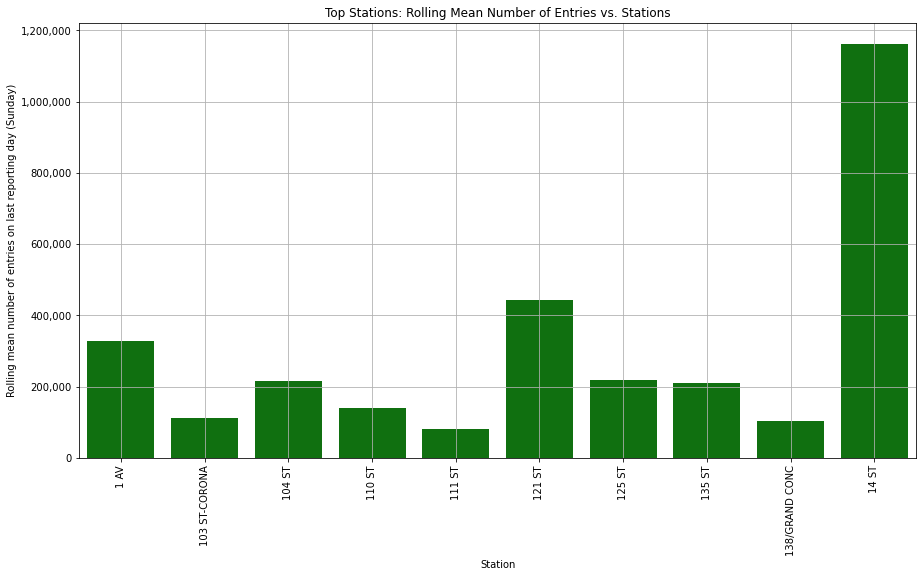

In [30]:
# Plot top stations: Rolling mean number of entres vs stations

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'STATION', y = 'ROLLING_MEAN', data = rolling_mean_group_top, color='green')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set(title='Top Stations: Rolling Mean Number of Entries vs. Stations')
ax.set(xlabel=('Station'))
ax.set(ylabel=('Rolling mean number of entries on last reporting day (Sunday)'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid();


One station outside of Manhattan is both in Queens and on the 7 train. 
Let's look at the stations along the 7 line in Queens. 

## 6. Plot 7 train stations in Queens 

In [31]:
seven_line_df = rolling_mean_df.copy() # Using df with rolling mean
seven_line_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
0,34 ST-PENN STA,2019-03-31 04:00:00,123,"17,001",6,"6,198,087"
1,34 ST-HERALD SQ,2019-03-31 04:00:00,BDFMNQRW,"78,790",6,"5,511,591"


In [32]:
# Looking for linename of interest: 7 line 
seven_line_df = seven_line_df[seven_line_df['LINENAME'].str.contains('7', na=False)] 
seven_line_df.head(10)
# The 7 train shares stations with other train lines. Will omit multi-train stations in this analysis. 
# Line name as recorded in dataset: 7


,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
5,42 ST-PORT AUTH,2019-03-31 04:00:00,ACENQRS1237W,"36,598",6,"3,474,060"
18,GRD CNTRL-42 ST,2019-03-31 04:00:00,4567S,"38,103",6,"2,829,847"
33,34 ST-HUDSON YD,2019-03-31 04:00:00,7,"19,111",6,"2,674,048"
39,42 ST-BRYANT PK,2019-03-31 04:00:00,BDFM7,"15,676",6,"2,400,286"
50,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,"2,000,721"
89,5 AVE,2019-03-31 04:00:00,7BDFM,"5,583",6,"1,651,434"
97,TIMES SQ-42 ST,2019-03-31 04:00:00,1237ACENQRS,"17,042",6,"1,538,861"
101,42 ST-BRYANT PK,2019-05-19 04:00:00,BDFM7,"19,682",6,"1,478,193"
116,COURT SQ,2019-03-31 04:00:00,7,"4,172",6,"1,312,422"
138,TIMES SQ-42 ST,2019-03-31 04:00:00,1237ACENQRSW,"45,572",6,"1,240,203"


In [33]:
# Mask selects the 7 train only stations
seven_mask = (seven_line_df['LINENAME'] == '7')
seven_line_df = seven_line_df[seven_mask]
seven_line_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
33,34 ST-HUDSON YD,2019-03-31 04:00:00,7,"19,111",6,"2,674,048"
50,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,"2,000,721"


In [34]:
# Comfirm df has only 7 line data
seven_line_df.LINENAME.unique()

array(['7'], dtype=object)

In [35]:
# How many 7 train stations in this dataset? 12
len(seven_line_df.STATION.unique())

12

In [36]:
# How many stations in Queens? All but one, 34 ST-HUDSON YD.   
seven_line_df.STATION.unique()

array(['34 ST-HUDSON YD', 'FLUSHING-MAIN', 'COURT SQ', 'VERNON-JACKSON',
       '46 ST BLISS ST', '90 ST-ELMHURST', '40 ST LOWERY ST',
       '82 ST-JACKSON H', '33 ST-RAWSON ST', '103 ST-CORONA', '111 ST',
       'JUNCTION BLVD'], dtype=object)

In [37]:
# Mask selects only the Queens stations
queens_mask = (seven_line_df['STATION'] != '34 ST-HUDSON YD')
seven_line_df = seven_line_df[queens_mask]
seven_line_df.head(5)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
50,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,"2,000,721"
116,COURT SQ,2019-03-31 04:00:00,7,"4,172",6,"1,312,422"
148,VERNON-JACKSON,2019-03-31 04:00:00,7,"10,591",6,"1,208,780"
158,46 ST BLISS ST,2019-03-31 04:00:00,7,"8,797",6,"1,158,996"
421,90 ST-ELMHURST,2019-03-31 04:00:00,7,"11,087",6,"830,892"


### Which 7 train stations in Queens have high late night entries? 

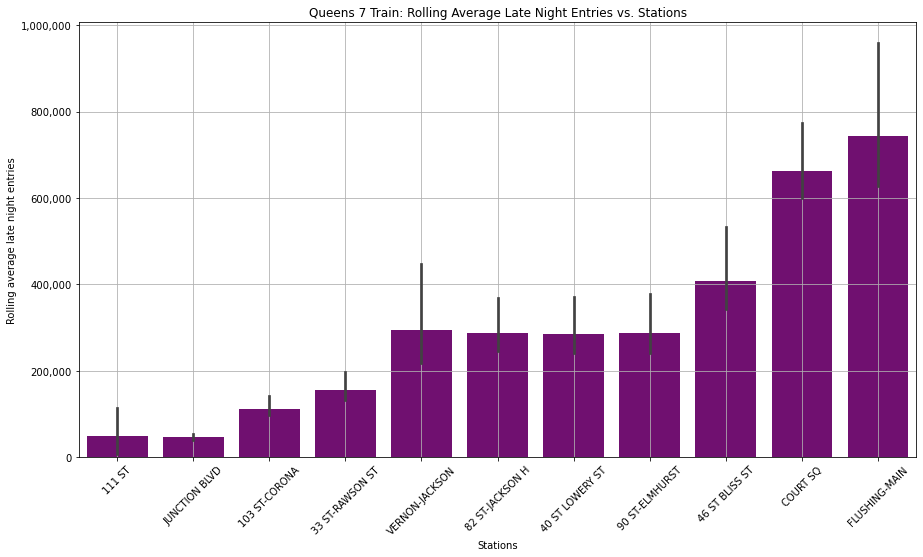

In [38]:
# Plot 7 line in Queens: Rolling average late night entries vs Queens 7 train stations

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'STATION', y = 'ROLLING_MEAN',data = seven_line_df.sort_values('ROLLING_MEAN'), color='purple')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set(title='Queens 7 Train: Rolling Average Late Night Entries vs. Stations')
ax.set(xlabel=('Stations'))
ax.set(ylabel=('Rolling average late night entries'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid();


The range of people entering a station on the 7 train during late-night hours varies. 
One station has high late night entries.<br/>
What days are the busiest at Flushing Station? 



## 7. Plot average late night entries at Flushing Station by day of week

In [39]:
flushing_df = late_night_entries_df.copy() # Using df without rolling mean

In [40]:
# Mask selects FLUSHING-MAIN
flushing_mask = (flushing_df['STATION'] == 'FLUSHING-MAIN')
flushing_df = flushing_df[flushing_mask]


In [41]:
# Confirm df only has Flushing data
flushing_df.STATION.unique()


array(['FLUSHING-MAIN'], dtype=object)

In [42]:
flushing_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK
14305,FLUSHING-MAIN,2019-03-30 04:00:00,7,"4,001,438",5
14306,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6


In [43]:
# Calculate Flushing WEEK_DAY_MEAN
flushing_df['WEEK_DAY_MEAN'] = (flushing_df
                                .groupby('DAY_OF_WEEK')['LATE_NIGHT_ENTRIES']
                                .transform(lambda x: x.mean()))
flushing_df.head(10)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,WEEK_DAY_MEAN
14305,FLUSHING-MAIN,2019-03-30 04:00:00,7,"4,001,438",5,"4,168,255"
14306,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,"27,901"
14307,FLUSHING-MAIN,2019-04-01 04:00:00,7,37,0,"20,948"
14308,FLUSHING-MAIN,2019-04-02 04:00:00,7,"57,655",1,"55,069"
14309,FLUSHING-MAIN,2019-04-03 04:00:00,7,"59,024",2,"58,079"
14310,FLUSHING-MAIN,2019-04-04 04:00:00,7,"59,802",3,"59,085"
14311,FLUSHING-MAIN,2019-04-05 04:00:00,7,"60,840",4,"58,426"
14312,FLUSHING-MAIN,2019-04-06 04:00:00,7,"4,016,794",5,"4,168,255"
14313,FLUSHING-MAIN,2019-04-07 04:00:00,7,"40,710",6,"27,901"
14314,FLUSHING-MAIN,2019-04-08 04:00:00,7,"31,202",0,"20,948"


In [44]:
# Mask selects every day but Saturday=5. 
# Saturdays may record people going out late to bars or nightclubs
saturday_mask = (flushing_df['DAY_OF_WEEK'] != 5)
flushing_df = flushing_df[saturday_mask]
flushing_df.head(5)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,WEEK_DAY_MEAN
14306,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,"27,901"
14307,FLUSHING-MAIN,2019-04-01 04:00:00,7,37,0,"20,948"
14308,FLUSHING-MAIN,2019-04-02 04:00:00,7,"57,655",1,"55,069"
14309,FLUSHING-MAIN,2019-04-03 04:00:00,7,"59,024",2,"58,079"
14310,FLUSHING-MAIN,2019-04-04 04:00:00,7,"59,802",3,"59,085"


### What days are the busiest at Flushing Station?

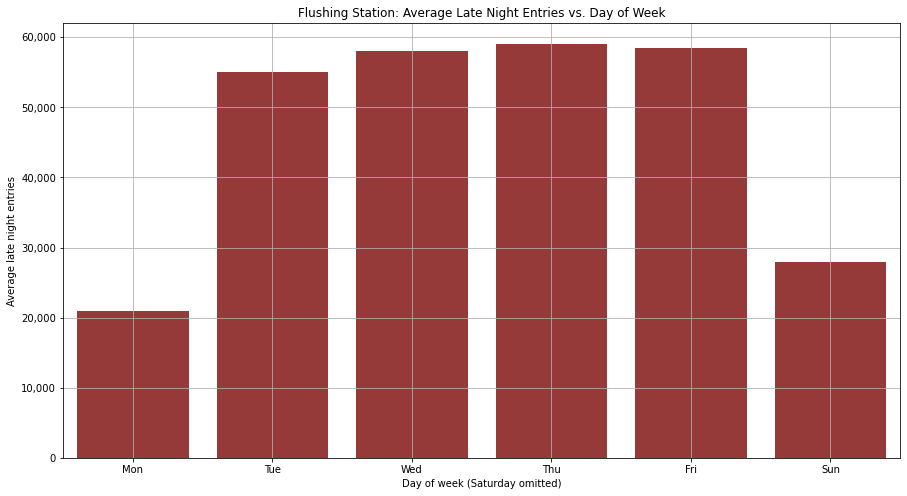

In [45]:
# Plot Flushing average week: Average late night entries vs day of week

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'DAY_OF_WEEK', y = 'WEEK_DAY_MEAN',data = flushing_df, color='brown')
ax.set(title='Flushing Station: Average Late Night Entries vs. Day of Week')
ax.set(xlabel=('Day of week (Saturday omitted)'))
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sun'],rotation = 0)
ax.set(ylabel=('Average late night entries'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid();


Tuesday through Friday have the highest late night entries at the Flushing station.